# Inspect Cell Trained Model

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

ROOT_DIR = os.getcwd()

sys.path.append(ROOT_DIR)
import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

import cell

%matplotlib inline 

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

CELL_WEIGHTS_PATH = "./mask_rcnn_cell.h5"

Using TensorFlow backend.


## Configurations

In [2]:
config = cell.CellConfig()
CELL_DIR = os.path.join(ROOT_DIR, "datasets/cell")

In [3]:
class InferenceConfig(config.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_PADDING                  True
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mr

## Notebook Preferences

In [4]:
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [6]:
dataset = cell.CellDataset()
dataset.load_cell(CELL_DIR, "val")
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 15
Classes: ['BG', 'cell']


## Load Model

In [7]:
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.


In [8]:
import tensorflow as tf 
print(tf.__version__)

2.1.0


In [9]:
weights_path = "./mask_rcnn_cell.h5"
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  ./mask_rcnn_cell.h5


## Run Detection

In [10]:
dataset.image_ids

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

image ID: cell.110.jpg (9) D:\Python\Data Mining\Project\Mask R-CNN\datasets/cell\val\110.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:   29.00000  max:  255.00000
molded_images            shape: (1, 1024, 1024, 3)    min:  -87.80000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000


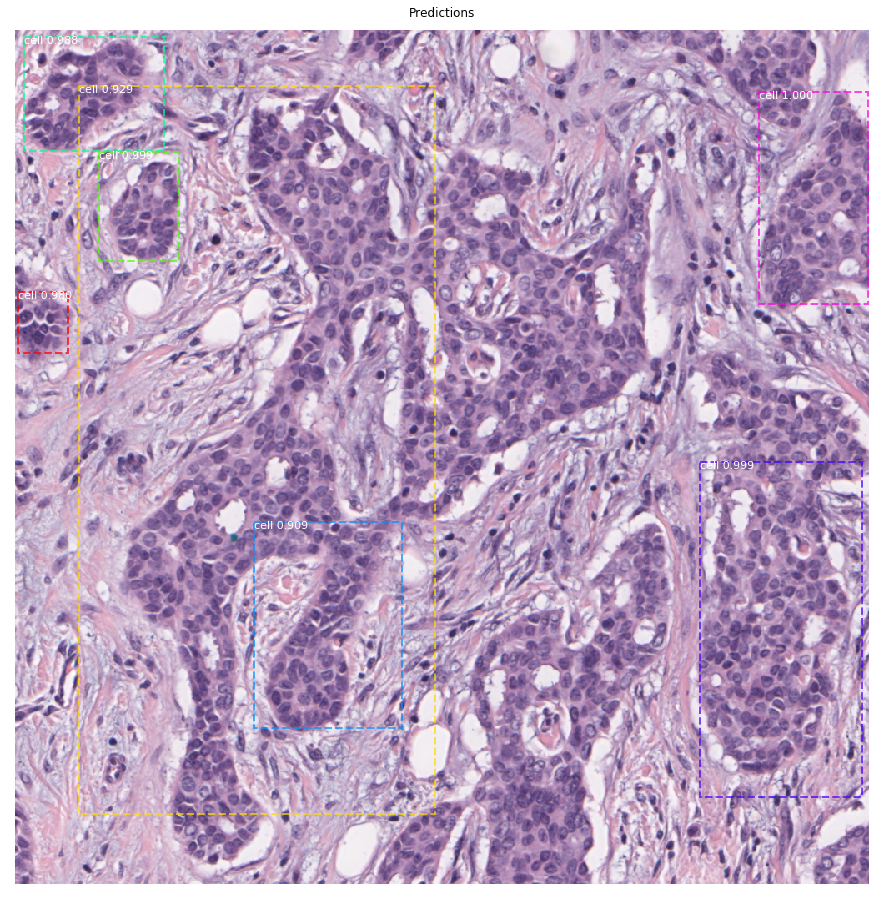

gt_class_id              shape: (12,)                 min:    1.00000  max:    1.00000
gt_bbox                  shape: (12, 4)               min:    0.00000  max: 1024.00000
gt_mask                  shape: (1024, 1024, 12)      min:    0.00000  max:    1.00000


In [34]:
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

results = model.detect([image], verbose=1)
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

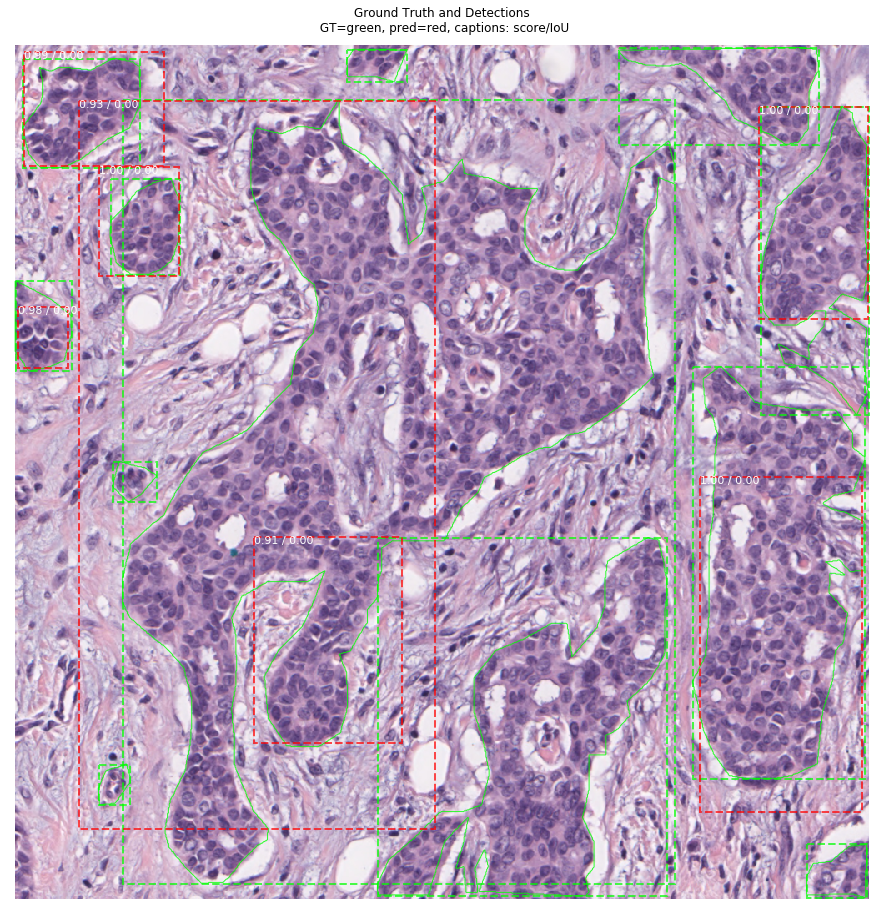

In [41]:
from mrcnn import visualize as mrcnn_visualize
mrcnn_visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=True, show_mask=False,
    iou_threshold=0.1, score_threshold=0.1)

## Average Precision

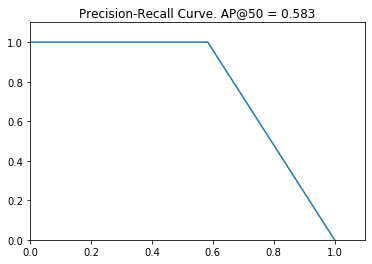

In [37]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], gt_mask) #r['masks']
visualize.plot_precision_recall(AP, precisions, recalls)